$$
min \frac{1}{2}\alpha^T\Delta x \Lambda^{-1}x\Delta \Delta + \frac{1}{C}(\alpha^T \alpha + \beta^T \beta + \alpha^T \beta  + \beta^T \alpha) - \sum_i^m \alpha_i
$$
где m - число примеров, n - число признаков
$$$$
$\alpha$, $\beta = [m,1]$, - двойтвенные переменные,
$$$$
$\Delta = diag(y_m)$ - диагональная матрица из y
$$$$
$\Lambda=diag((|w_n|+r)^{p-2})$
$$$$
$x= [x_m,x_n]$
$$$$
$y=[m,1]$
$$$$
$b=[m,1]$
$$$$
$w= [m,1]$
$$$$
C = const
$$$$
$\xi_i = [m,1]$ - резервные переменные (slack)
$$$$
$w^T=\alpha^T \Delta x \Lambda^{-1}$
$$$$
$\xi_i = \frac{1}{C}(\alpha + \beta)$ - резервные переменные (slack)
$$$$
Предположение: $r = [r_1,...,r_N], r=range(0,N,r/N)$
$$$$
Понимане: \\
Вход: x, y, w0 (инициализация нулями), C, p, r (в цикле поэтому не задаём), N (Чисор итераций),
1. два цикла по p и k \\
2. вычисляем $\Lambda$ и $\Delta$(хз зачем, тк оно константное [это метки класса])
3. минимизируем дуальную задачу. Выход: $\alpha,\beta$
4. Проверка условие (хз какого [мб на сходимость eps < 1e-5]). True: break, False: continue.
5. вычисляем $w^{k+1}, \Lambda^{k+1}$


In [ ]:
import numpy as np
from cvxopt import matrix
from cvxopt import solvers

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
import seaborn as sns; sns.set()
import cvxpy as cp

In [ ]:
def linear_kernel(x1: np.array,
                  x2: np.array):
    return np.dot(x1, x2)

def poly_kernel(x1: np.array,
                x2: np.array, degree: int, coef0: float):
    return np.power(np.dot(x1, x2.T)+coef0, degree)

def gaussian_kernel(x1: np.array,
                    x2: np.array, variance=1.):
    return np.exp(-np.square(np.linalg.norm(x1-x2, axis = (len(x1.shape)-1))) / 2*variance)

In [ ]:
def generate_noisy_data(data : np.array, noise_variance):
    dimension = len(data)

    # Длина вектора шума
    rho = np.random.normal(0, noise_variance) # В теории должно быть при сдернем 0 и дисп 1 в диапозоне [-3,3] (правило 3 сигм)

    # Угол поворота вектора шума (для 2D он один)
    phi = np.random.uniform(0, 2*np.pi) # А этот в диапозоне [0, 6.283185307179586]

    return np.array([data[0] + rho * np.cos(phi), data[1] + rho * np.sin(phi)])

In [ ]:
class SVM:
    def __init__(self, C=1., kernel='linear', r = 0.8, p=1.5, step = 0.1, noise=0, **kernel_args):
        self.C = C
        self.r = r
        self.p = p
        self.noise = noise
        self.step = step
        self.kernel_type = kernel
        self.kernel = {'linear': linear_kernel,
                      'poly': poly_kernel,
                      'gaussian': gaussian_kernel}[kernel]
        self.kernel_args = kernel_args
        self.weight = 0
        self.bias = 0
        self.lambdas = np.array([])
        self.trained = False
        self.tested = False

    def fit(self,
            features: np.array,
            labels: np.array):

        self.x = x = features
        self.y = y = labels

        # размерность объектов и признаков
        n, m = x.shape
        # инициализация начального приближения
        self.eps = 1e-10
        w0 = np.array([1/np.sqrt(1+1),1/np.sqrt(2+1)])
        Delta = np.diag(y)
        self.Lambda = Lambda = [np.diag(np.power(w0, 2-2))]
        alphas = [np.zeros(n)]
        w = [w0]

        # случай для 0 < p < inf
        if self.p < 2:
            p_k = np.arange(2 - self.step,self.p - self.step, -self.step)
            k = 2
            for p in p_k:
                # p = round(p, 2)
                print(f'k={k}')
                print(f'p={p}')
                r_k = self.r/k

                try:
                  alphas.append(self._solver(Delta, Lambda[-1]))
                except ValueError:
                  print("BREAK!!!!!!!")
                  break

                w.append(alphas[-1].T @ Delta @ self.x @ np.linalg.inv(Lambda[-1]))


                Lambda.append(np.diag(np.power(abs(w[-1]) + r_k, p-2)))

                k += 1

        # случай для p >= 2
        elif self.p >= 2:
            if self.p == 2:
                p_k = np.array([2])
            else:
                p_k = np.arange(2 + self.step, self.p + self.step, self.step)
            k = 2
            for p in p_k:
                # p = round(p, 3)
                print(f'p:{p}')
                # Обновление вектора двойственных переменных lambda
                try:
                  alphas.append(self._solver(Delta, Lambda[-1]))
                except ValueError:
                  print("BREAK!!!!!!!")
                  break
                # if np.linalg.norm(alphas[-1] - alphas[-2], ord=2) < self.eps:
                #     print('EXIT b.o COND__________________________________________')
                #     break

                # обновление вектора весов w
                w.append(alphas[-1].T @ Delta @ self.x @ np.linalg.inv(Lambda[-1]))

                # обновление матрицы Lambda
                Lambda.append(np.diag(np.power(abs(w[-1]), p-2)))

                k += 1

        self.lambdas = lambdas =  alphas[-1]
        self.sv_indices = (lambdas > 1e-5*self.C)
        self.bsv_indices = np.where((lambdas < .999*self.C) & self.sv_indices)
        self.support_vectors = x[self.sv_indices]
        self.border_support_vectors = x[self.bsv_indices]

        XV = np.matmul(self.x, np.linalg.inv(self.Lambda[-1]))
        self.V_sv = XV[self.sv_indices]

        self.weight = w[-1]
        self.bias = self._calc_bias()

        self.trained = True

    def _solver(self, Delta, Lambda):
        n, m = self.x.shape

        XV = np.matmul(self.x, np.linalg.inv(Lambda))
        K = np.array([[self.kernel(XV[i], self.x[j], **self.kernel_args) for i in range(n)] for j in range(n)])


        P = matrix(Delta @ K @ Delta)
        q = matrix(-np.ones((n, 1)))
        G = matrix(np.vstack((-np.eye(n), np.eye(n))))
        h = matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))
        A = matrix(self.y.reshape((1, -1)))
        b = matrix(np.zeros(1))
        solvers.options['show_progress'] = False

        sol = solvers.qp(P, q, G, h, A, b)
        alpha = np.array(sol['x']).flatten()

        return alpha

    def _calc_weight(self):
        return (self.lambdas[self.sv_indices] * self.y[self.sv_indices]) @ self.support_vectors


    def _calc_bias(self):
        lambd = self.lambdas[self.sv_indices]
        sv = self.V_sv
        bsv = self.border_support_vectors
        y_sv = self.y[self.sv_indices]
        y_bsv = self.y[self.bsv_indices]
        return np.median(y_bsv - [lambd * y_sv @ self.kernel(sv, x, **self.kernel_args) for x in bsv])

    def decision_function(self, x):
        if self.trained:
            lambd = self.lambdas[self.sv_indices]
            y = self.y[self.sv_indices]
            sv = self.V_sv
            b = self.bias
            return np.array([lambd * y @ self.kernel(sv, xi, **self.kernel_args) + b for xi in x])
        else:
            return print('Please train this model with some data first.')

    def predict(self, x):
        return np.sign(self.decision_function(x))

    def test(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        self.y_predict = self.predict(x_test)
        self.errors = (sum(self.y_predict != y_test) / len(y_test) * 100).round(5)
        self.tested = True
        return self.errors

    def plot(self, plot='single', axes=None, title=''):
        self.xlim = xlim = [np.min(self.x[:, 0]), np.max(self.x[:, 0])]
        self.ylim = ylim = [np.min(self.x[:, 1]), np.max(self.x[:, 1])]
        xx, yy = np.meshgrid(np.linspace(*xlim, num=250), np.linspace(*ylim, num=250))
        z = self.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        x_bsv, y_bsv = self.border_support_vectors, self.y[self.bsv_indices]
        x_sv, y_sv = self.support_vectors, self.y[self.sv_indices]

        color1, color2 = '#AB2E2E', '#518484'
        point_style = 'o'

        if plot == 'single':
            plt.figure(figsize=(10, 8))

        if plot == 'multi':
            plt.axes(axes)

        if plot == 'points':
            plt.figure(figsize=(10, 8))
            p1 = plt.scatter(self.x[self.y<0, 0], self.x[self.y<0, 1], s=70, color=color1, alpha=0.75, marker=point_style,label='- класс "-1"')
            p2 = plt.scatter(self.x[self.y>0, 0], self.x[self.y>0, 1], s=70, color=color2, alpha=0.75, marker=point_style, label='- класс "1"')
            plt.legend()
            return None

        #background
        plt.contourf(xx, yy, np.sign(z), levels=2, colors=[color1, color2], alpha=0.25)
        #lines
        plt.contour(xx, yy, z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k', alpha=0.5)
        #'class -1' & 'class 1' points
        p1 = plt.scatter(self.x[self.y<0, 0], self.x[self.y<0, 1], s=70, color=color1, alpha=0.75, marker=point_style)
        p2 = plt.scatter(self.x[self.y>0, 0], self.x[self.y>0, 1], s=70, color=color2, alpha=0.75, marker=point_style)
        #'class -1' & 'class 1' support vectors
        sv1 = plt.scatter(x_sv[y_sv<0, 0], x_sv[y_sv<0, 1], s=100, edgecolor='k', color=color1, alpha=0.8, marker=point_style)
        sv2 = plt.scatter(x_sv[y_sv>0, 0], x_sv[y_sv>0, 1], s=100, edgecolor='k', color=color2, alpha=0.8, marker=point_style)

        plots = [(p2, p1), (sv2, sv1)]
        labels = ['- периферийные объекты', '- опорные объекты']

        kernel = 'ядро: '

        if self.kernel_type == 'linear':
            kernel += 'линейное'

        if self.kernel_type == 'poly':
            kernel += 'полиномиальное, ' + 'степень = ' + str(self.kernel_args['degree']) + ', ' + 'c = ' + str(self.kernel_args['coef0'])

        if self.kernel_type == 'gaussian':
            kernel += 'гауссовское, ' + 'σ^2 = ' + str(self.kernel_args['variance'])

        title_ = kernel + ';' + ' C = ' + str(self.C) + '\nобучающая выборка: ' + str(len(self.x))

        if self.tested:
            cond1 = (self.x_test[:, 0] >= self.xlim[0]) & (self.x_test[:, 0] <= self.xlim[1])
            cond2 = (self.x_test[:, 1] >= self.ylim[0]) & (self.x_test[:, 1] <= self.ylim[1])
            x_test = self.x_test[cond1 & cond2]
            y_test = self.y_test[cond1 & cond2]

            tp1 = plt.scatter(x_test[y_test < 0, 0], x_test[y_test < 0, 1], s = 70, marker='.', color = color1, alpha=0.75)
            tp2 = plt.scatter(x_test[y_test > 0, 0], x_test[y_test > 0, 1], s = 70, marker='.', color = color2, alpha=0.75)

            plots.append((tp2, tp1))
            # labels.append('- тестовая выборка')
            title_ += '\nошибки: ' + str(self.errors) + '%'

        title_ += title

        h_map = {tuple: HandlerTuple(ndivide=None, pad = 0.5)}
        plt.legend(plots, labels, handler_map=h_map, loc='upper right', fontsize='x-large', markerscale=1.7)
        if plot == 'single':
            plt.suptitle('Метод опорных векторов')

        plt.title(title_)
        plt.savefig(f'L{self.p}_reg_C_{self.C}_r_{self.r}_step_{self.step}_noise_{self.noise}.png')


p:2.1
p:2.2
p:2.3000000000000003
p:2.4000000000000004
p:2.5000000000000004
p:2.6000000000000005
p:2.7000000000000006
p:2.8000000000000007
p:2.900000000000001
p:3.000000000000001
p:3.100000000000001
p:3.200000000000001
p:3.300000000000001
p:3.4000000000000012
p:3.5000000000000013
p:3.6000000000000014
p:3.7000000000000015
p:3.8000000000000016
p:3.9000000000000017
p:4.000000000000002
p:4.100000000000001
p:4.200000000000002
p:4.3000000000000025
p:4.400000000000002
p:4.500000000000002
p:4.600000000000002
p:4.700000000000003
p:4.8000000000000025
p:4.900000000000002
p:5.000000000000003
p:2
k=2
p=1.99
k=3
p=1.98
k=4
p=1.97
k=5
p=1.96
k=6
p=1.95
k=7
p=1.94
k=8
p=1.93
k=9
p=1.92
k=10
p=1.91
k=11
p=1.9
k=12
p=1.89
k=13
p=1.88
k=14
p=1.8699999999999999
k=15
p=1.8599999999999999
k=16
p=1.8499999999999999
k=17
p=1.8399999999999999
k=18
p=1.8299999999999998
k=19
p=1.8199999999999998
k=20
p=1.8099999999999998
k=21
p=1.7999999999999998
k=22
p=1.7899999999999998
k=23
p=1.7799999999999998
k=24
p=1.769999

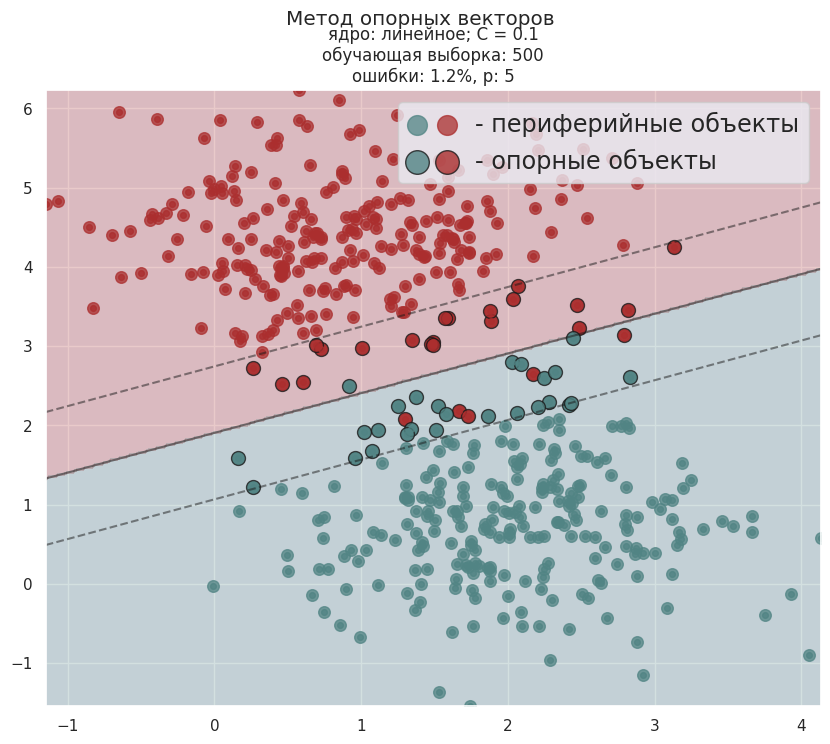

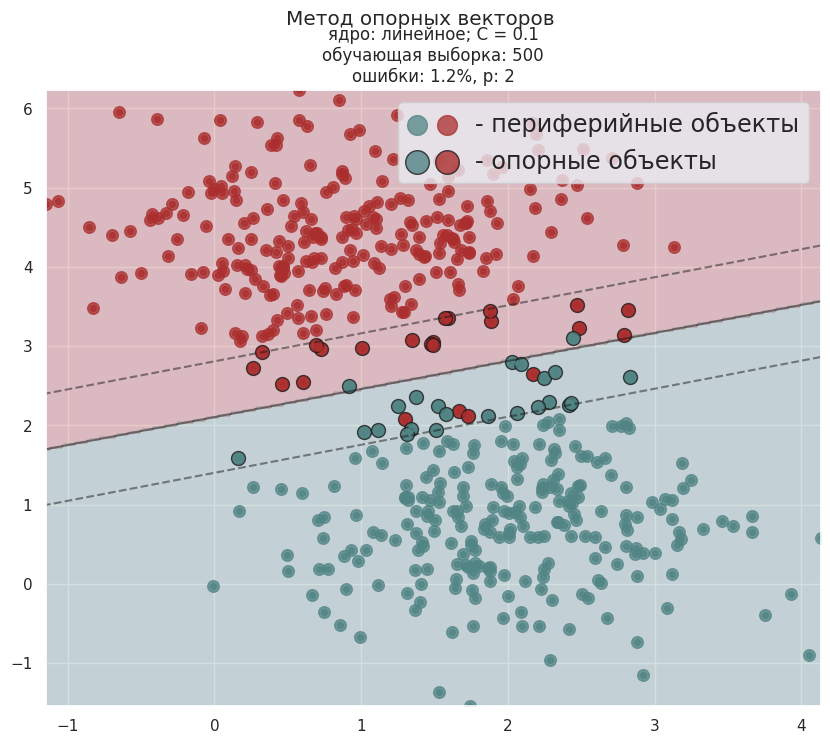

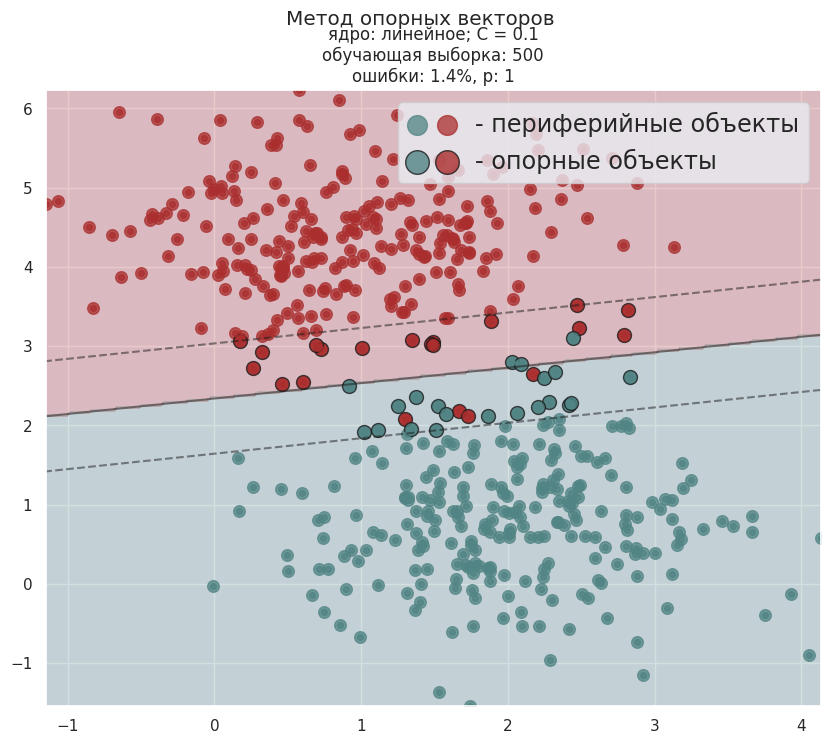

In [ ]:
from sklearn.datasets import make_blobs, make_circles, make_classification



X, Y = make_blobs(n_samples=500, centers=2, random_state=0, cluster_std=0.8)

#переобразование классов из (0, 1) в (-1, 1)
Y = 2.*Y - 1

svm = SVM(C=0.1, kernel='linear', p = 5, r=0.01, step=0.1)
svm.fit(X, Y)
svm.test(X, Y)
svm.plot(title = f', p: {str(svm.p)}')

svm = SVM(C=0.1, kernel='linear', p = 2, r=0.01, step=0.05)
svm.fit(X, Y)
svm.test(X, Y)
svm.plot(title = f', p: {str(svm.p)}')

svm = SVM(C=0.1, kernel='linear', p = 1, r=0.00001, step=0.01)
svm.fit(X, Y)
svm.test(X, Y)
svm.plot(title = f', p: {str(svm.p)}')


p:2
p:2
p:2


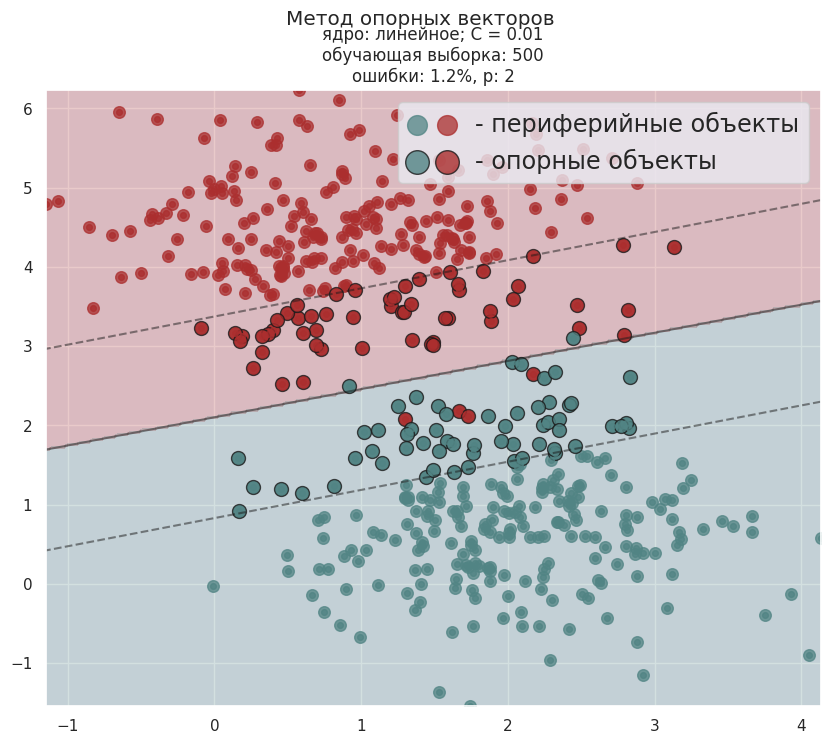

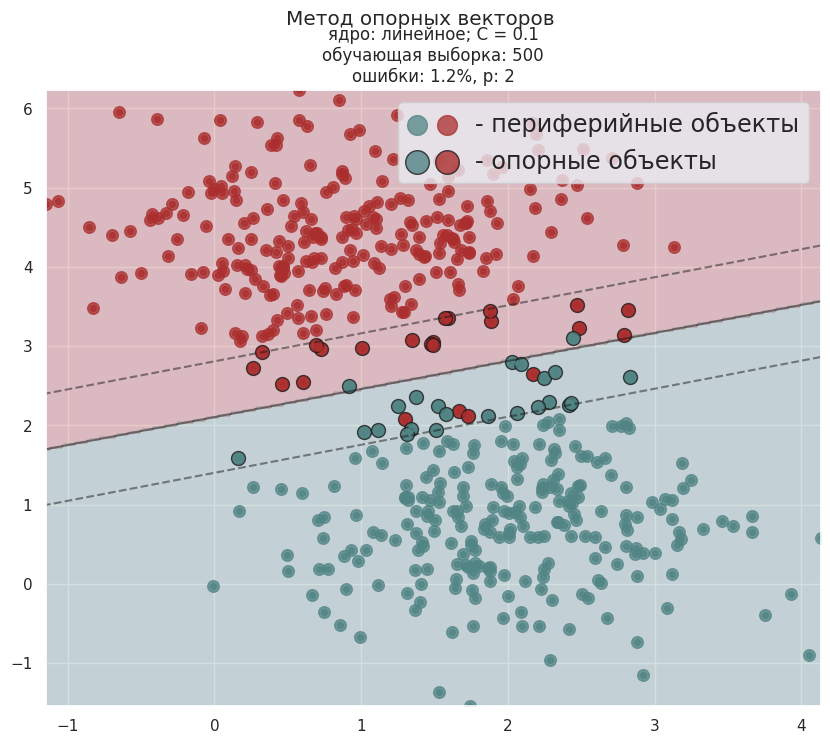

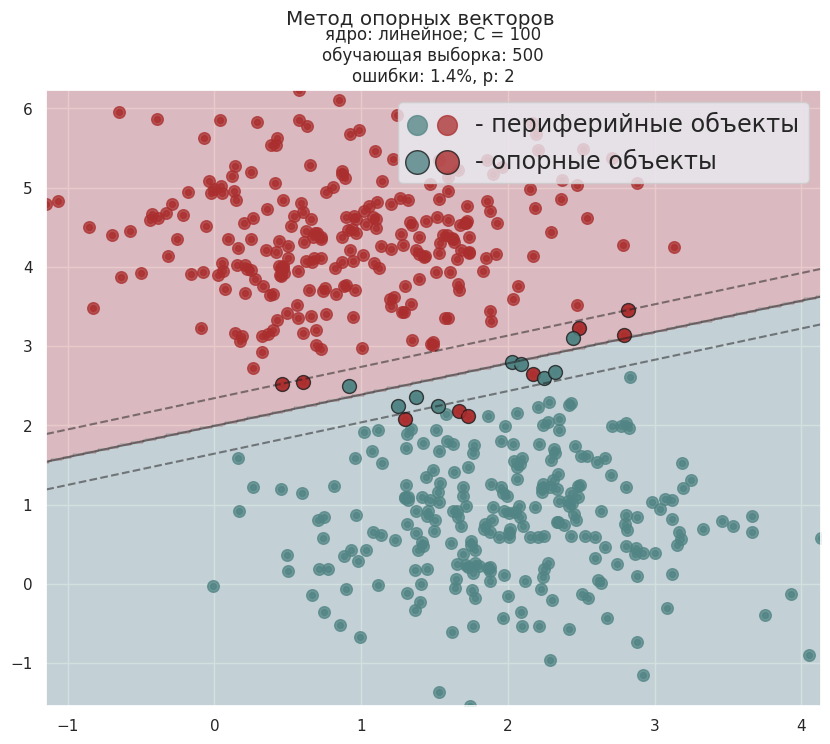

In [ ]:
from sklearn.datasets import make_blobs, make_circles, make_classification

X, Y = make_blobs(n_samples=500, centers=2, random_state=0, cluster_std=0.8)

#переобразование классов из (0, 1) в (-1, 1)
Y = 2.*Y - 1

#разбиение выборки на обучающую и тестовую
n_train_points = round(.8*len(X))
x_train, x_test = X[:n_train_points], X[n_train_points:]
y_train, y_test = Y[:n_train_points], Y[n_train_points:]



for C in [0.01, 0.1, 100]:
    svm = SVM(C=C, kernel='linear', p = 2, r=0.00001, step=0.1)
    svm.fit(X, Y)
    svm.test(X, Y)
    svm.plot(title = f', p: {str(svm.p)}')


#print(svm.weight)

p:2
p:2
p:2


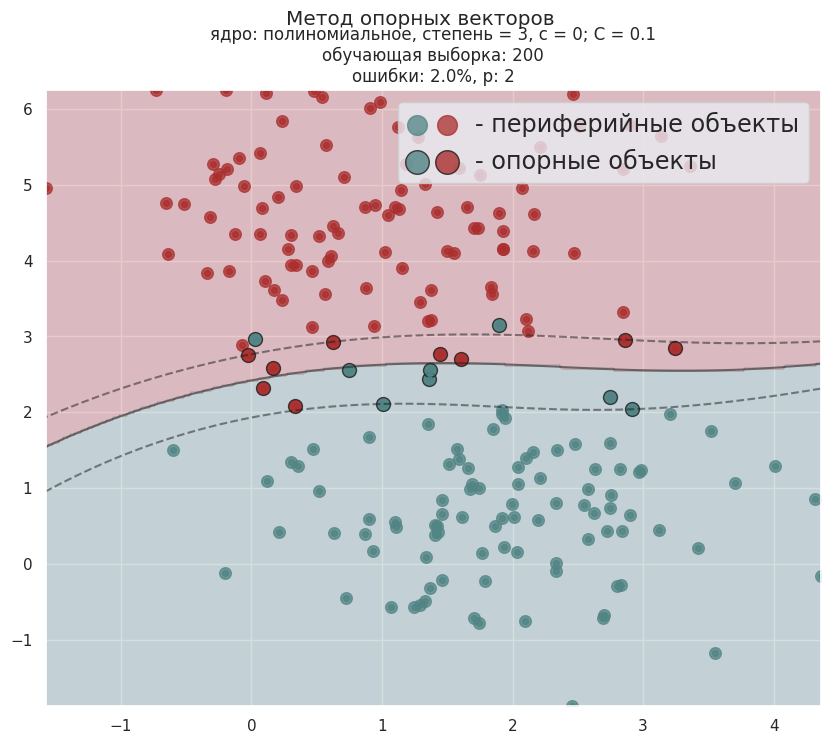

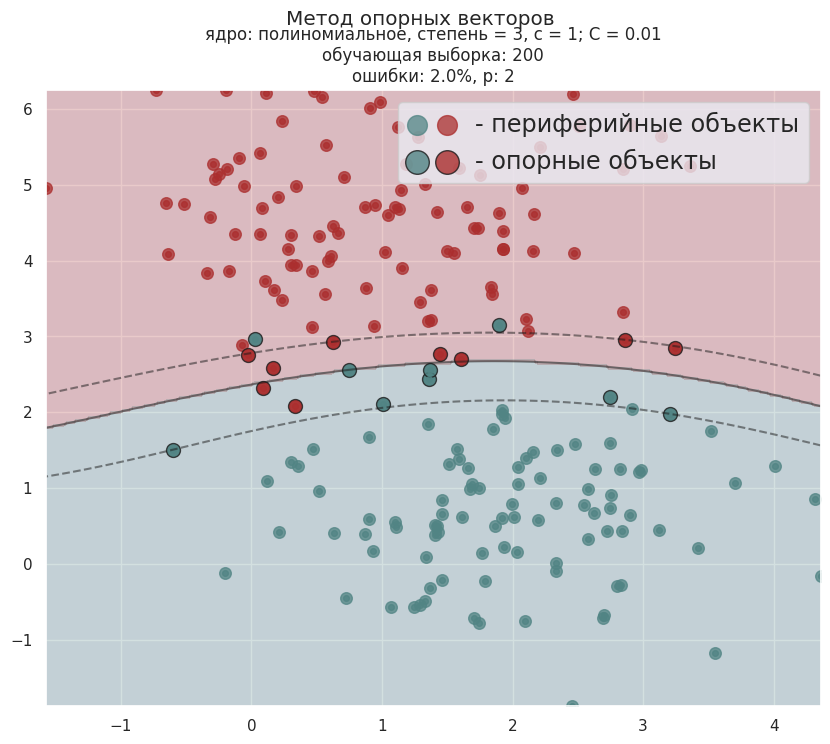

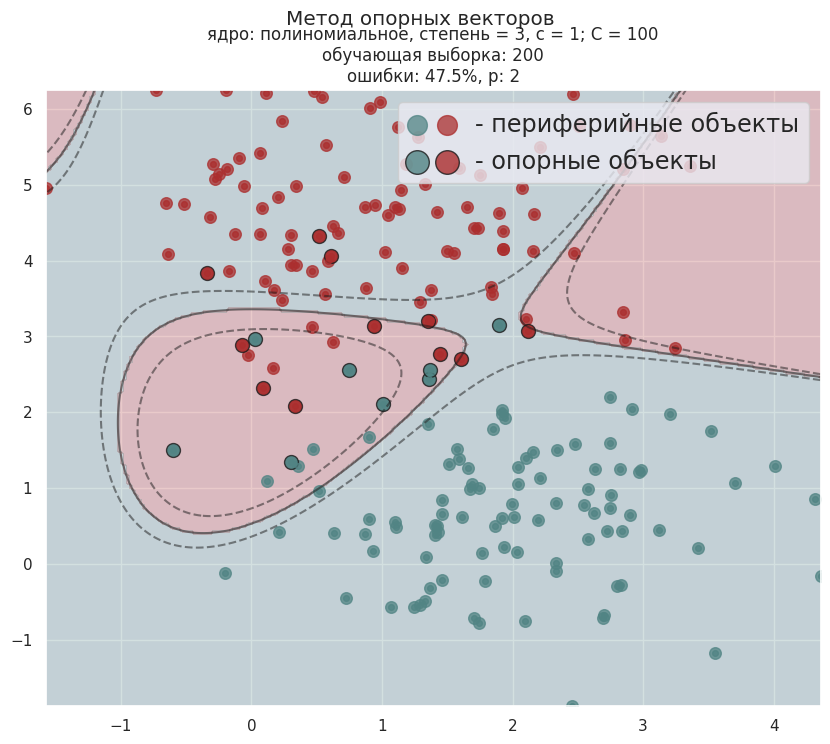

In [ ]:
from sklearn.datasets import make_blobs, make_circles, make_classification

X, Y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=1)

#переобразование классов из (0, 1) в (-1, 1)
Y = 2.*Y - 1


svm = SVM(C=0.1, kernel='poly', p = 2, r=0.01, degree = 3, coef0 = 0, step = 0.01)
svm.fit(X, Y)
svm.test(X, Y)
svm.plot(title = f', p: {str(svm.p)}')

svm = SVM(C=0.01, kernel='poly', p = 2, r=0.01, degree = 3, coef0 = 1, step = 0.01)
svm.fit(X, Y)
svm.test(X, Y)
svm.plot(title = f', p: {str(svm.p)}')

svm = SVM(C=100, kernel='poly', p = 2, r=0.01, degree = 3, coef0 = 1, step = 0.01)
svm.fit(X, Y)
svm.test(X, Y)
svm.plot(title = f', p: {str(svm.p)}')

Text(0, 0.5, 'Процент ошибок')

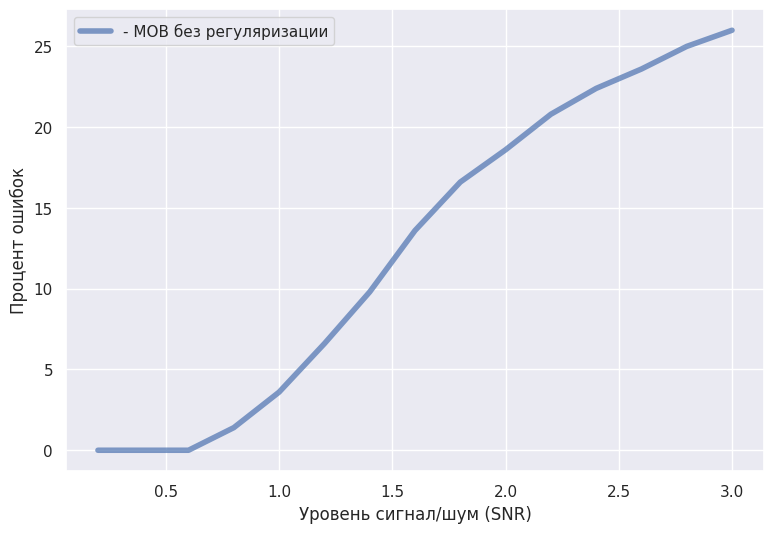

In [ ]:
x = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3]
y1 = [0, 0, 0, 1.4, 3.6, 6.6, 9.8, 13.6, 16.6, 18.6, 20.8, 22.4, 23.6, 25, 26]
plt.figure(figsize=(9, 6))
plt.plot(x, y1, label="- МОВ без регуляризации", lw=4, alpha=0.7)
plt.legend()
plt.xlabel("Уровень сигнал/шум (SNR)")
plt.ylabel("Процент ошибок")

Text(0, 0.5, 'Процент ошибок')

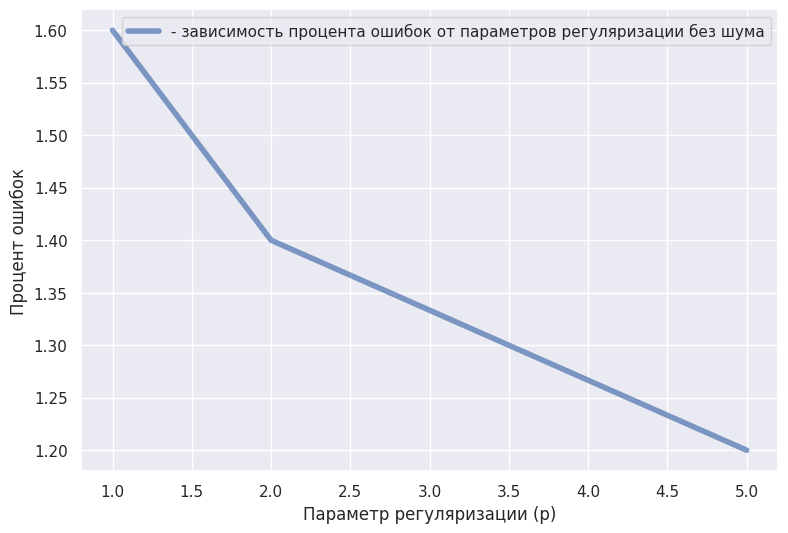

In [ ]:
x = [1, 2, 5]
y1 = [1.6, 1.4, 1.2]
plt.figure(figsize=(9, 6))
plt.plot(x, y1, label="- зависимость процента ошибок от параметров регуляризации без шума", lw=4, alpha=0.7)
plt.legend()
plt.xlabel("Параметр регуляризации (p)")
plt.ylabel("Процент ошибок")

Text(0, 0.5, 'Процент ошибок')

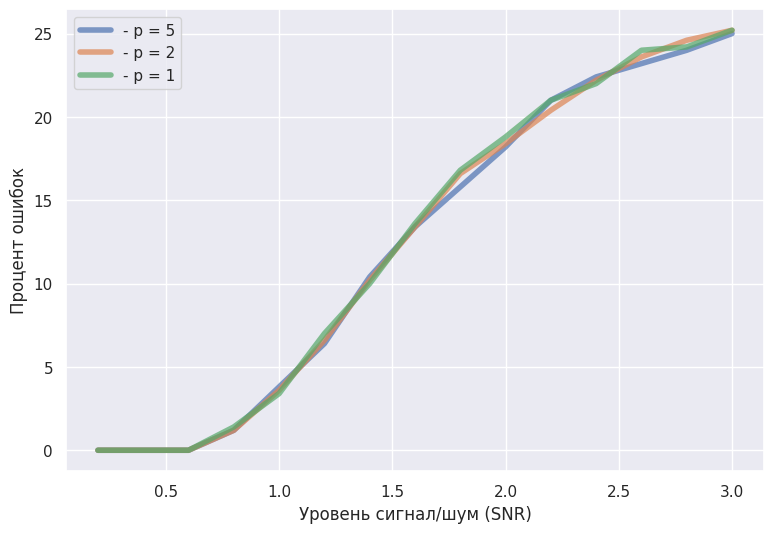

In [ ]:
x = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3]
y1 = [0, 0, 0, 1.2, 3.8, 6.4, 10.4, 13.4, 15.8, 18.2, 21, 22.4, 23.2, 24, 25]
y2 = [0, 0, 0, 1.2, 3.6, 6.6, 10.2, 13.4, 16.6, 18.4, 20.4, 22.2, 23.6, 24.6, 25.2]
y3 = [0, 0, 0, 1.4, 3.4, 7, 10, 13.6, 16.8, 18.8, 21, 22, 24, 24.2, 25.2]
plt.figure(figsize=(9, 6))
plt.plot(x, y1, label="- p = 5", lw=4, alpha=0.7)
plt.plot(x, y2, label="- p = 2", lw=4, alpha=0.7)
plt.plot(x, y3, label="- p = 1", lw=4, alpha=0.7)
plt.legend()
plt.xlabel("Уровень сигнал/шум (SNR)")
plt.ylabel("Процент ошибок")

## ГЕНЕРАЦИЯ ДАННЫХ

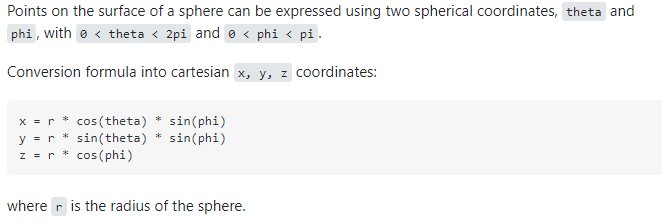

In [ ]:
X, Y = make_blobs(n_samples=500, centers=2, random_state=0, cluster_std=1.1)
Y = 2.*Y - 1

In [ ]:
import numpy as np

def generate_noisy_data(data : np.array, noise_variance):
    dimension = len(data)

    # Длина вектора шума
    rho = np.random.normal(0, noise_variance) # В теории должно быть при сдернем 0 и дисп 1 в диапозоне [-3,3] (правило 3 сигм)

    # Угол поворота вектора шума (для 2D он один)
    phi = np.random.uniform(0, 2*np.pi) # А этот в диапозоне [0, 6.283185307179586]

    noisy_data = []
    # Прибавление шума
    [noisy_data.append([obj[0] + rho * np.cos(phi), obj[1] + rho * np.sin(phi)]) for obj in data]

    return np.array(noisy_data)

data = np.array([[1.0, 1.0],[2,5],[3,3],[0,1]])  # Данные
noise_variance = 1 # Шум

print("data:", data)
print('noise:', noise_variance)
noisy_data = generate_noisy_data(data, noise_variance)
print("Noisy data:", noisy_data)

data: [[1. 1.]
 [2. 5.]
 [3. 3.]
 [0. 1.]]
noise: 1
Noisy data: [[2.00100842 0.02188288]
 [3.00100842 4.02188288]
 [4.00100842 2.02188288]
 [1.00100842 0.02188288]]
